## TODO
- fokusirati se na garden door klasifikaciju za sada
    - dodati extra data u dataset
- odredivanje label 0 
- label 0 najsigurnije pogledati nocu
- plottati label 0 i sto ne izgleda kao da je mogu izbaciti (do 5%)
- kompresija label 0 podataka
- kako se parametri ponasaju u label 0
- 5 fold cross validation
- DOLJE TODOs SU ZA MODEL KOJI KOMBINIRA PARAMETRE KAKO BI NAPRAVIO PREDICTION
- https://hal.science/hal-04432021v1/document, feature selection
- https://www.mdpi.com/2673-4591/5/1/24

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import seaborn as sns
import json

- 16/10/2024 14:47 -> 16/10/2024 16:26 FALSE OPEN
- 18/10/2024 19:08 -> 18/10/2024 19:08 FALSE CLOSE
- 19/10/2024 13:34 -> 19/10/2024 14:07 FALSE CLOSE
- 19/10/2024 17:08 -> 19/10/2024 18:49 FALSE OPEN
- 21/10/2024 08:50 -> 21/10/2024 08:51 FALSE CLOSE (?)
- 22/10/2024 08:55 -> 22/10/2024 08:55 FALSE CLOSE (?)
- 22/10/2024 08:57 -> 22/10/2024 08:59 FALSE OPEN 
- 22/10/2024 10:41 -> 22/10/2024 10:45 FALSE OPEN
- 22/10/2024 12:59 -> 22/10/2024 13:00 FALSE CLOSE
- 22/10/2024 16:48 -> 22/10/2024 16:49 FALSE CLOSE
- 23/10/2024 08:14 -> 23/10/2024 08:16 FALSE CLOSE
.........



## Data loading and preprocessing

In [45]:
# Load and preprocess door and window data
garden_door_df = pd.read_csv('datasets/Door_windows.csv')
garden_door_df = garden_door_df.drop('Door_balcony_1st_floor', axis=1)
garden_door_df = garden_door_df.drop('Door_Hallway', axis=1)
garden_door_df['Date'] = pd.to_datetime(garden_door_df['Date'], format='%d/%m/%Y %H:%M')
garden_door_df['Door_Garden'] = garden_door_df['Door_Garden'].map({'on': 1, 'off': 0})
garden_door_df = garden_door_df.drop_duplicates(subset='Date', keep='last')

# RESAMPLANJE U 1 SEKUNDU
garden_door_df.set_index('Date', inplace=True)
garden_door_df = garden_door_df.resample('1s').ffill()
garden_door_df.reset_index(inplace=True)
garden_door_df = garden_door_df.drop('Unnamed: 0', axis=1)
#garden_door_df.to_csv("datasets/garden_door_dataset.csv", index=False)

sensor_df = pd.read_csv('datasets/LS0623020168.csv')
# Convert UTC to UTC+2
sensor_df['timestamp(ZG)'] = pd.to_datetime(sensor_df['timestamp(UTC)']) + timedelta(hours=2)

# Handling daylight savings (UTC+1)
dst_cutoff = pd.Timestamp('2024-10-27 03:00:00')
sensor_df['timestamp(ZG)'] = sensor_df['timestamp(ZG)'].apply(
    lambda x: x - timedelta(hours=1) if x >= dst_cutoff else x
)

merged_df = pd.merge(sensor_df, garden_door_df[["Date", "Door_Garden"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = merged_df.drop(columns=["Date"])
merged_df = merged_df[merged_df["timestamp(ZG)"] >= garden_door_df['Date'].min()]

# Dropping duplicated values of timestamp resulted in moving the clock by 1 hour
merged_df = merged_df.drop_duplicates(subset='timestamp(ZG)', keep='first')

#merged_df.to_csv("datasets/merged_sensor_data.csv", index=False)

### Filtering out times of experiments being done

In [46]:
with open("datasets/experiments.json", "r") as file:
    experiment_data = json.load(file)

# Convert the experiment intervals into a DataFrame
intervals = []
for experiment, times in experiment_data["experiments"].items():
    for time_range in times:
        intervals.append({"start": pd.to_datetime(time_range[0]), "end": pd.to_datetime(time_range[1])})
intervals = intervals[1:]   # OSTAVLJAMO DOOR OPENING
intervals_df = pd.DataFrame(intervals)

# Filter out rows within the intervals
for _, row in intervals_df.iterrows():
    merged_df = merged_df[
        ~((merged_df['timestamp(ZG)'] >= row['start']) & (merged_df['timestamp(ZG)'] <= row['end']))
    ]
    
merged_df = merged_df.dropna()
#merged_df.to_csv("datasets/merged_sensor_data_no_experiments.csv", index=False)

## Visualizing the data

In [4]:
# Visualizing the whole dataset
"""
# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of paramaters', fontsize=16)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(sensor_df['timestamp(ZG)'], sensor_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

axs[7,1].plot(merged_df['timestamp(ZG)'],merged_df['any_door_open'])
axs[7,1].set_title('Any door open')
axs[7,1].set_xlabel('Time')
axs[7,1].set_ylabel('Yes (1), No (0)')
axs[7,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of paramaters', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),\n    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),\n    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),\n    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),\n    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),\n    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),\n    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),\n    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')\n]\n\n# Plot each parameter in a separate s

For visualizing door opening, the data is reduced from 5s to 1m readings, the sensor data is the average value in that 1 minute, each day is saved as image in daily_plots

In [47]:
# Generating images by days
import os

parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

merged_df = merged_df.drop('timestamp(UTC)', axis=1)

# Set the UTC+1 timestamp as the index
merged_df.set_index('timestamp(ZG)', inplace=True)

# Resample the data to 1-minute intervals and calculate the mean
data_resampled = merged_df.resample('1min').mean()

# Reset the index to make 'timestamp(ZG)' a column again
data_resampled = data_resampled.reset_index()

# Ensure the directory for saving plots exists
output_dir = "daily_plots3"
os.makedirs(output_dir, exist_ok=True)

# Loop through each unique day in the dataset
data_resampled['date'] = data_resampled['timestamp(ZG)'].dt.date
unique_days = data_resampled['date'].unique()

for day in unique_days:
    # Filter data for the specific day
    day_data = data_resampled[data_resampled['date'] == day]
    open_door_times = day_data[day_data['Door_Garden'] == 1]['timestamp(ZG)']
    
    # Set up a figure for the subplots
    fig, axs = plt.subplots(8, 2, figsize=(15, 22))
    fig.suptitle(
        f'Time series of parameters for {day}, red line = garden door open, blue line = hallway door open', 
        fontsize=16
    )
    
    # Plot each parameter in a separate subplot
    for i, (param, title) in enumerate(parameters):
        row, col = divmod(i, 2)
        axs[row, col].plot(day_data['timestamp(ZG)'], day_data[param])
        axs[row, col].set_title(title)
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel(title)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # Add vertical lines for door open times with color
        for open_time in open_door_times:
            open_time_door_data = day_data[day_data['timestamp(ZG)'] == open_time]
            if (open_time_door_data['Door_Garden'].values == 1):
                axs[row, col].axvline(x=open_time, color='red', lw=1, alpha=0.2)
    
    # Remove unused subplots if they exist
    for j in range(len(parameters), len(axs.flatten())):
        fig.delaxes(axs.flatten()[j])
    
    # Adjust layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.savefig(os.path.join(output_dir, f'{day}.png'))
    plt.close(fig)

In [6]:
# Code for plotting current days
"""
#20-21 3 min generiranje, u 11.2 sekunde
start_time = '2024-10-13'  
end_time = '2024-10-20'

merged_df.set_index('timestamp(ZG)', inplace=True)
data_resampled = merged_df.resample('1T').mean()
data_resampled = data_resampled.reset_index()

filtered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of parameters smaller interval, red line = garden door open, blue line = hallway door open', fontsize=16)

# List of parameters and titles
parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    #('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

open_door_times = filtered_resampled_df[filtered_resampled_df['any_door_open'] == 1]['timestamp(ZG)']

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(filtered_resampled_df['timestamp(ZG)'], filtered_resampled_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

    # Add vertical lines for door open times with color
    for open_time in open_door_times:
        open_time_door_data = filtered_resampled_df[filtered_resampled_df['timestamp(ZG)'] == open_time]
        if (open_time_door_data['Door_Garden'].values == 1):
            axs[row, col].axvline(x=open_time, color='red', linestyle='--', lw=1, alpha=0.01)
        if (open_time_door_data['Door_Hallway'].values == 1):
            axs[row, col].axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.01)

# Remove unused subplots if they exist
for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\n#20-21 3 min generiranje, u 11.2 sekunde\nstart_time = '2024-10-13'  \nend_time = '2024-10-20'\n\nmerged_df.set_index('timestamp(ZG)', inplace=True)\ndata_resampled = merged_df.resample('1T').mean()\ndata_resampled = data_resampled.reset_index()\n\nfiltered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]\n\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of parameters smaller interval, red line = garden door open, blue line = hallway door open', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n   

We can see that although the correlation matrix doesn't give the best correlations results there is a clear correlation in the plots between rapid change of co2, 03, co etc. parameters and the door being opened. 
Thesis: using derivations (amount of change through time) to predict when the doors are opened. In other words, the doors are definitely opened when there is a bigger change in paramaters. Another thing to note is that we should try other ways of prepping the training data, other than putting it straight in.

## Analysis of data

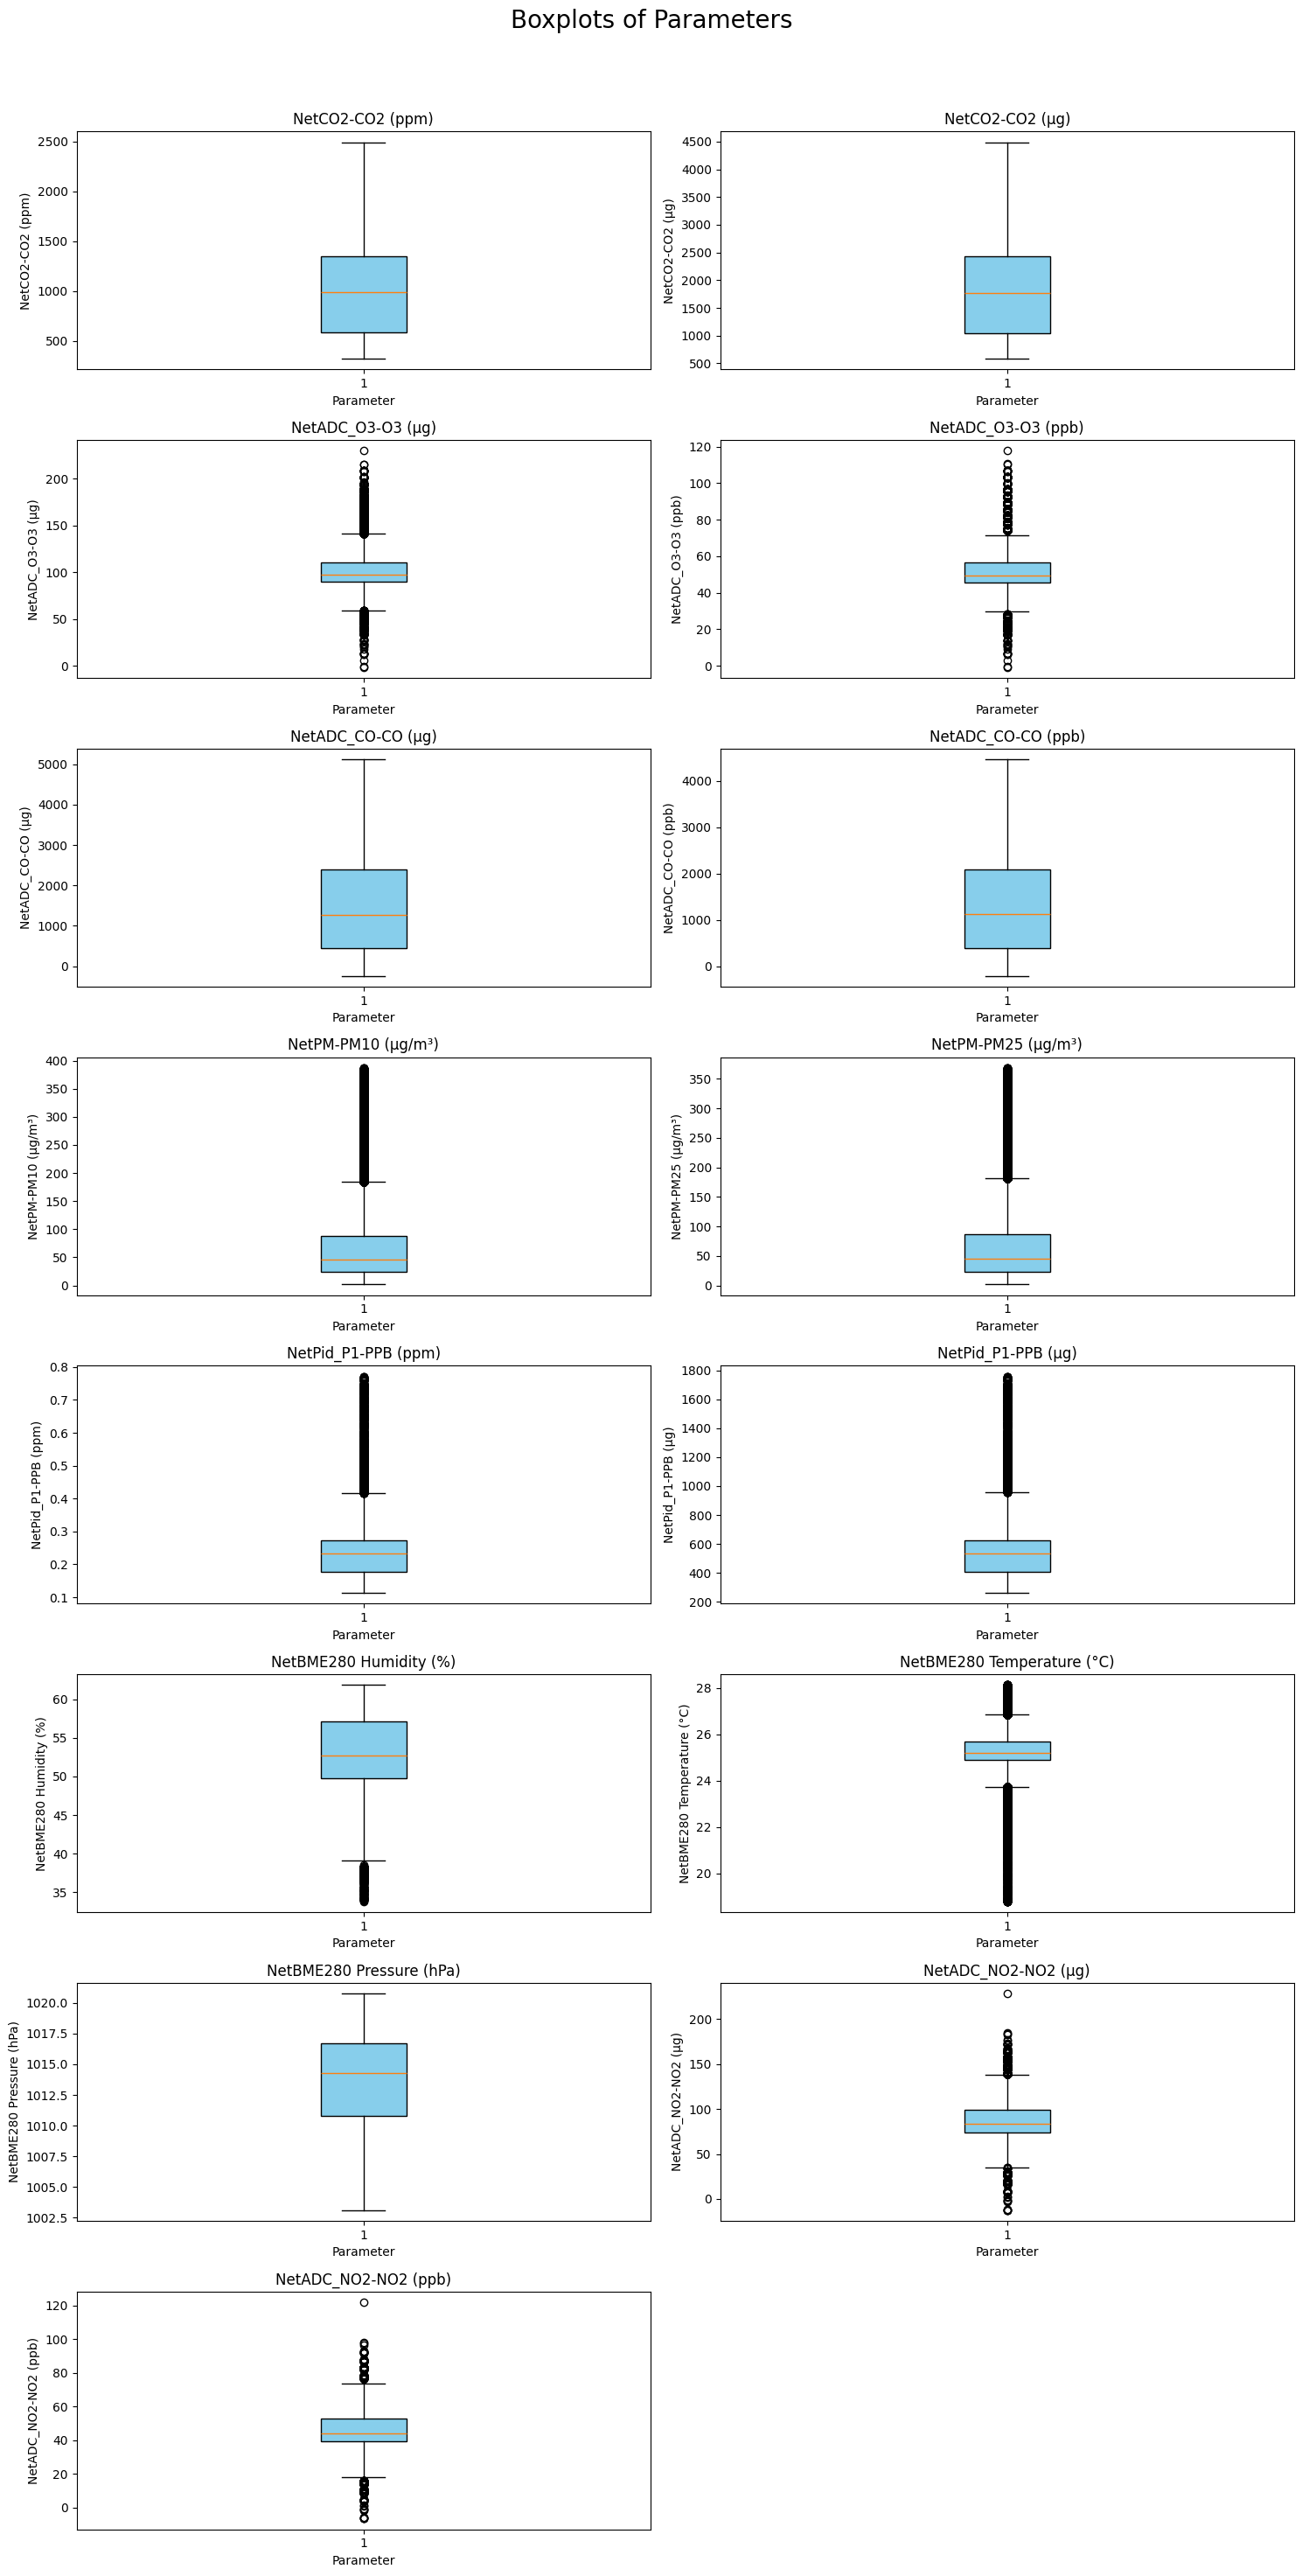

In [7]:
import matplotlib.pyplot as plt

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Boxplots of Parameters', fontsize=20)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot as a boxplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    box = axs[row, col].boxplot(merged_df[param].dropna(),
                                patch_artist=True,  # Enables coloring
                                boxprops=dict(facecolor='skyblue', color='black'))
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xlabel('Parameter')
    axs[row, col].set_ylabel(title)

for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

### Outlier analysis

In [8]:
parameters = [
    "NetCO2-CO2(ppm)", "NetCO2-CO2_ug", "NetADC_O3-O3_ug", "NetADC_O3-O3(ppb)", 
    "NetADC_CO-CO_ug", "NetADC_CO-CO( ppb)", "NetPM-PM10(µg/m3)", "NetPM-PM25(µg/m3)", 
    "NetPid_P1-PPB(ppm)", "NetPid_P1-PPB_ug", "NetBME280-PERC(%)", "NetBME280-TEMP_EXT(°C)", 
    "NetBME280-HPA(hPa)", "NetADC_NO2-NO2_ug", "NetADC_NO2-NO2(ppb)"
]

outlier_counts = {}
outlier_percentages = {}

total_rows = len(merged_df)

for param in parameters:
    Q1 = merged_df[param].quantile(0.25)
    Q3 = merged_df[param].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = merged_df[(merged_df[param] < lower_bound) | (merged_df[param] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / total_rows) * 100
    
    outlier_counts[param] = outlier_count
    outlier_percentages[param] = outlier_percentage

print("Outlier counts and percentages for each parameter:\n")
for param in parameters:
    print(f"{param}: {outlier_counts[param]} outliers ({outlier_percentages[param]:.2f}%)")

Outlier counts and percentages for each parameter:

NetCO2-CO2(ppm): 0 outliers (0.00%)
NetCO2-CO2_ug: 0 outliers (0.00%)
NetADC_O3-O3_ug: 5284 outliers (1.73%)
NetADC_O3-O3(ppb): 5042 outliers (1.65%)
NetADC_CO-CO_ug: 0 outliers (0.00%)
NetADC_CO-CO( ppb): 0 outliers (0.00%)
NetPM-PM10(µg/m3): 37537 outliers (12.26%)
NetPM-PM25(µg/m3): 36576 outliers (11.94%)
NetPid_P1-PPB(ppm): 1167 outliers (0.38%)
NetPid_P1-PPB_ug: 1167 outliers (0.38%)
NetBME280-PERC(%): 253 outliers (0.08%)
NetBME280-TEMP_EXT(°C): 23915 outliers (7.81%)
NetBME280-HPA(hPa): 0 outliers (0.00%)
NetADC_NO2-NO2_ug: 957 outliers (0.31%)
NetADC_NO2-NO2(ppb): 806 outliers (0.26%)


Most outliers are with the NetPM-PM10(µg/m3) and NetPM-PM25(µg/m3) readings, looking at the plots, the readings stay around 10-100 but on Oct 21 - Oct 25, they go up to 300-350, also a higher amount on Oct 30 and 31 with a maximum of around 180, this is not a failed sensor reading and the values should not be removed

### Correlation matrix, removed ppm/ug readings where applicable

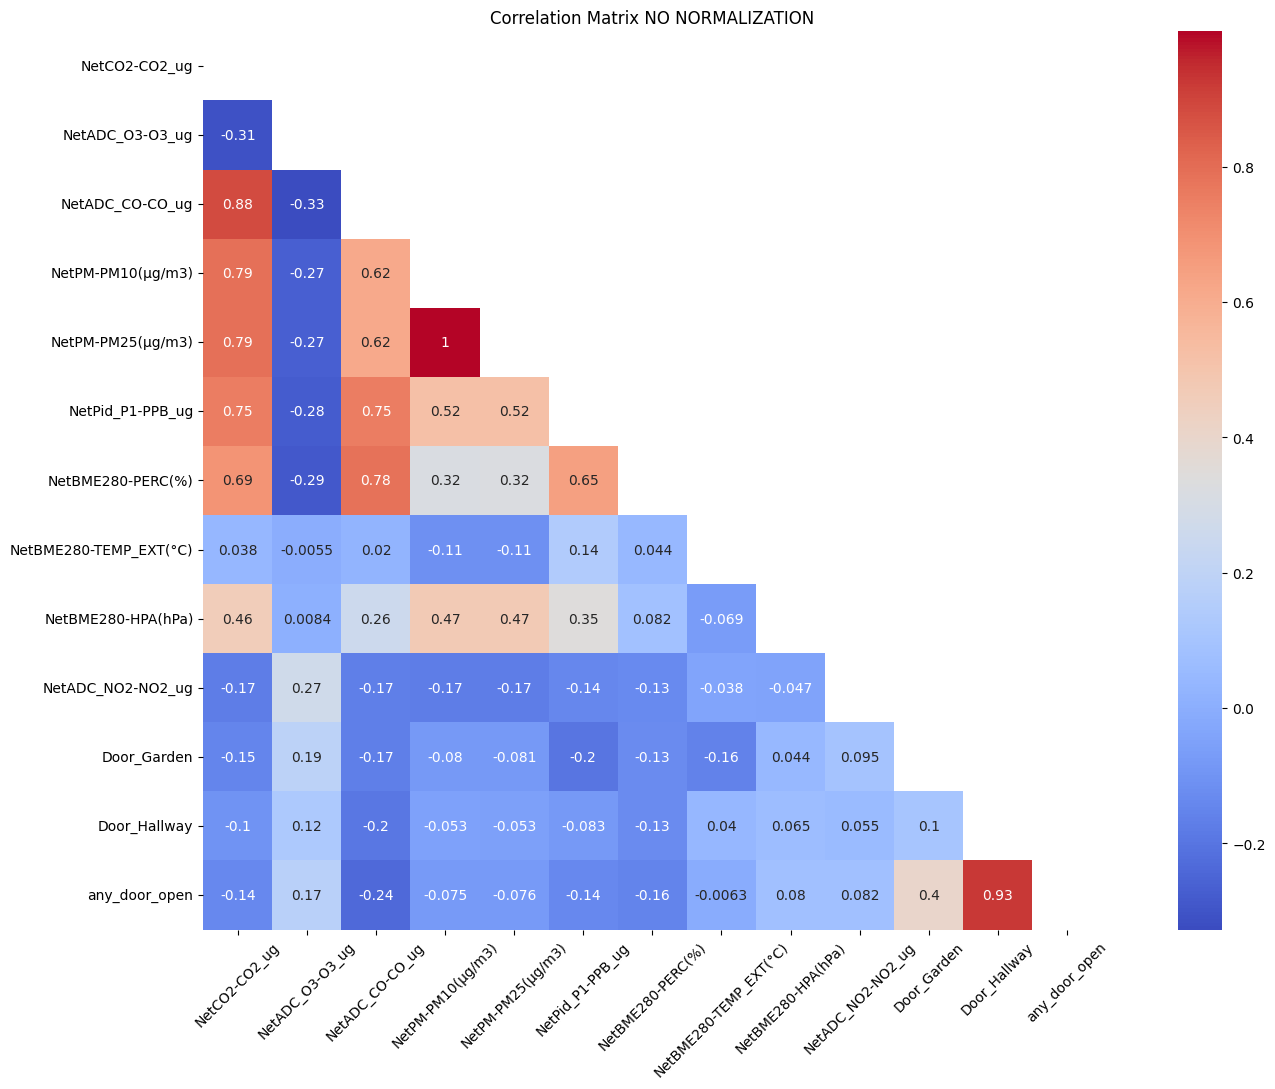

In [9]:
columns_to_consider = [
    'NetCO2-CO2_ug', 'NetADC_O3-O3_ug','NetADC_CO-CO_ug', 'NetPM-PM10(µg/m3)', 
    'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'Door_Garden', 
    'Door_Hallway', 'any_door_open'
]

df_subset = merged_df[columns_to_consider]
correlation_matrix = df_subset.corr()


plt.figure(figsize=(16, 11))
#sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), square=True)

plt.title('Correlation Matrix NO NORMALIZATION')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Data normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

parameters_to_normalize = [
    'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
    'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
    'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)'
]

#scaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization
scaler = StandardScaler()
sensor_df_normalized = merged_df.copy()
sensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])

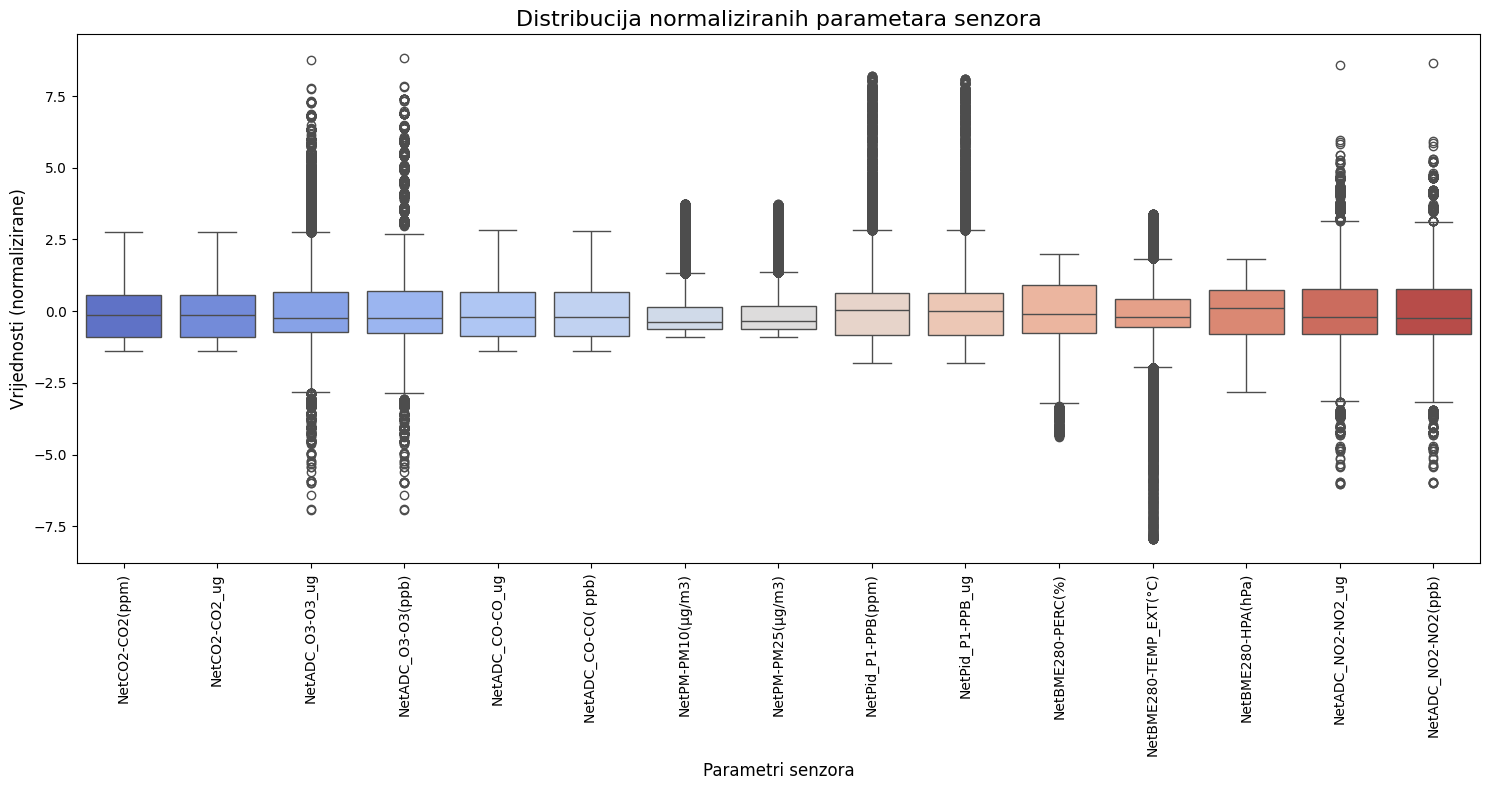

In [11]:
data_to_plot = sensor_df_normalized[parameters_to_normalize]

plt.figure(figsize=(15, 8))  # Set the figure size
sns.boxplot(data=data_to_plot, orient='v', palette='coolwarm')

plt.title('Distribucija normaliziranih parametara senzora', fontsize=16)  # Plot title in Croatian
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Parametri senzora', fontsize=12)
plt.ylabel('Vrijednosti (normalizirane)', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

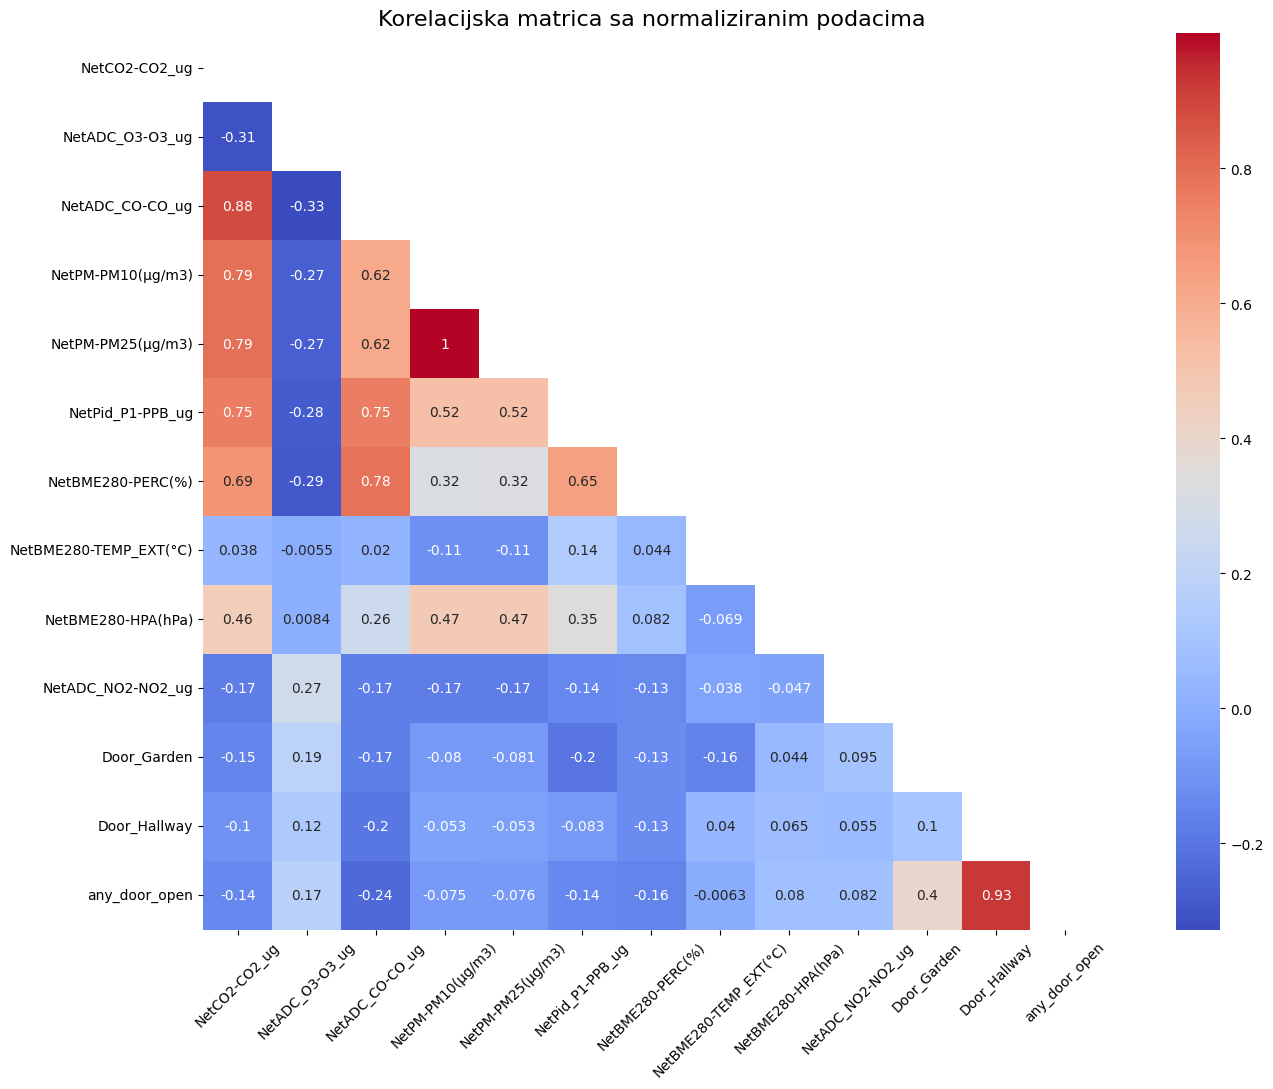

In [12]:
# Generate correlation matrix
correlation_matrix = sensor_df_normalized[columns_to_consider].corr()

plt.figure(figsize=(16, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), square=True)
plt.title("Korelacijska matrica sa normaliziranim podacima", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Correlation matrix with normalized data is the same as the corr. matrix with un-normalized data

## PCA Analysis

In [13]:
from sklearn.decomposition import PCA

parameters_for_PCA = [
    'NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 
    'NetBME280-TEMP_EXT(°C)', 'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug'
]

pca = PCA(n_components=10)
X_pca = pca.fit_transform(sensor_df_normalized[parameters_for_PCA])

In [14]:
pca_unnormalized = PCA(n_components=10)
X_pca_unnormalized = pca_unnormalized.fit_transform(merged_df[parameters_for_PCA])

### Scree plot

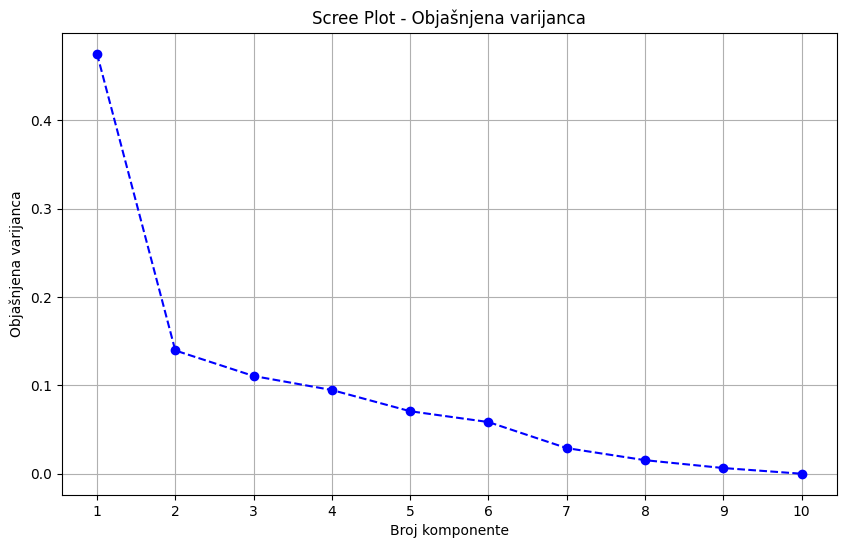

In [15]:
# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
components = np.arange(1, len(pca.explained_variance_ratio_) + 1)  # Component indices
plt.plot(components, pca.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Objašnjena varijanca')
plt.xlabel('Broj komponente')
plt.ylabel('Objašnjena varijanca')
plt.xticks(components)
plt.grid()
plt.show()


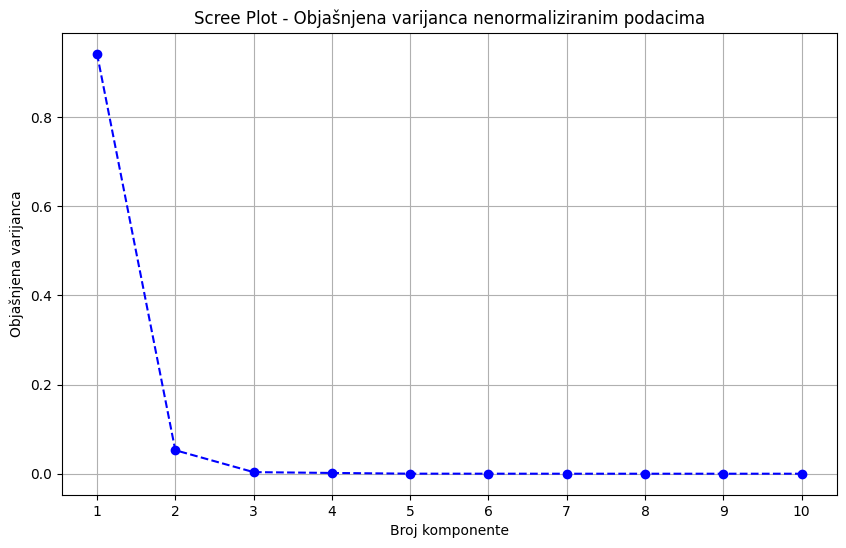

In [16]:
# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
unnormalized_components = np.arange(1, len(pca_unnormalized.explained_variance_ratio_) + 1)  # Component indices
plt.plot(unnormalized_components, pca_unnormalized.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Objašnjena varijanca nenormaliziranim podacima')
plt.xlabel('Broj komponente')
plt.ylabel('Objašnjena varijanca')
plt.xticks(unnormalized_components)  # Ensure all components are shown on x-axis
plt.grid()
plt.show()

### Cumulative Explained Variance

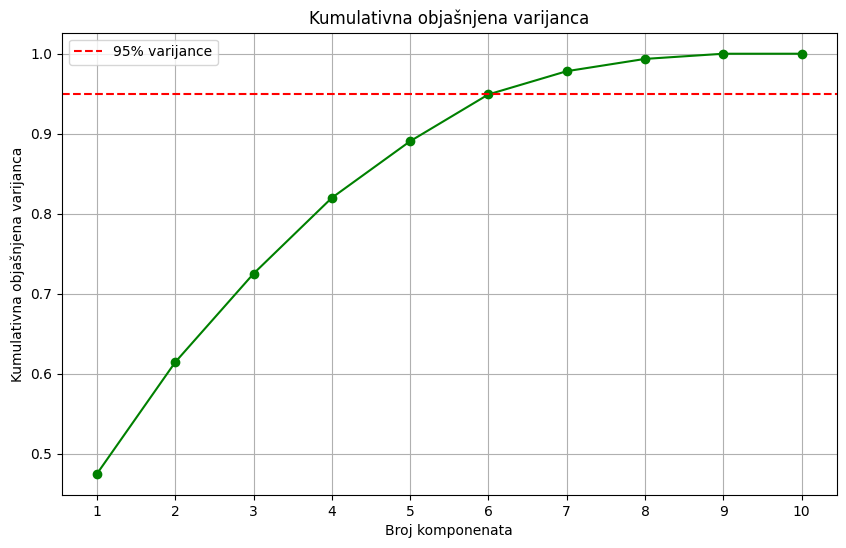

In [17]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(components, cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Kumulativna objašnjena varijanca')
plt.xlabel('Broj komponenata')
plt.ylabel('Kumulativna objašnjena varijanca')
plt.xticks(components)
plt.grid()

# Add a threshold line (e.g., 95% variance explained)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varijance')
plt.legend()
plt.show()


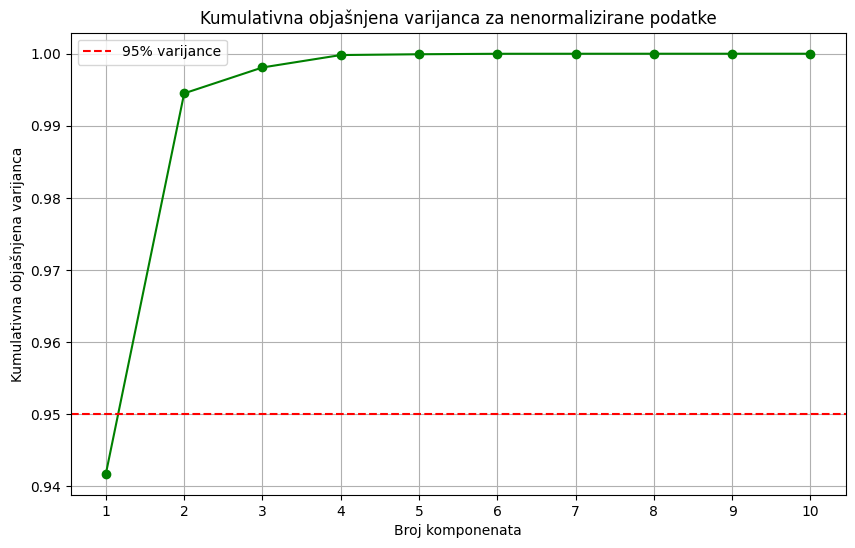

In [18]:
# Cumulative explained variance
unnormalized_cumulative_variance = np.cumsum(pca_unnormalized.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(unnormalized_components, unnormalized_cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Kumulativna objašnjena varijanca za nenormalizirane podatke')
plt.xlabel('Broj komponenata')
plt.ylabel('Kumulativna objašnjena varijanca')
plt.xticks(unnormalized_components)
plt.grid()

# Add a threshold line (e.g., 95% variance explained)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varijance')
plt.legend()
plt.show()

### PCA Loadings (Feature Contribution)

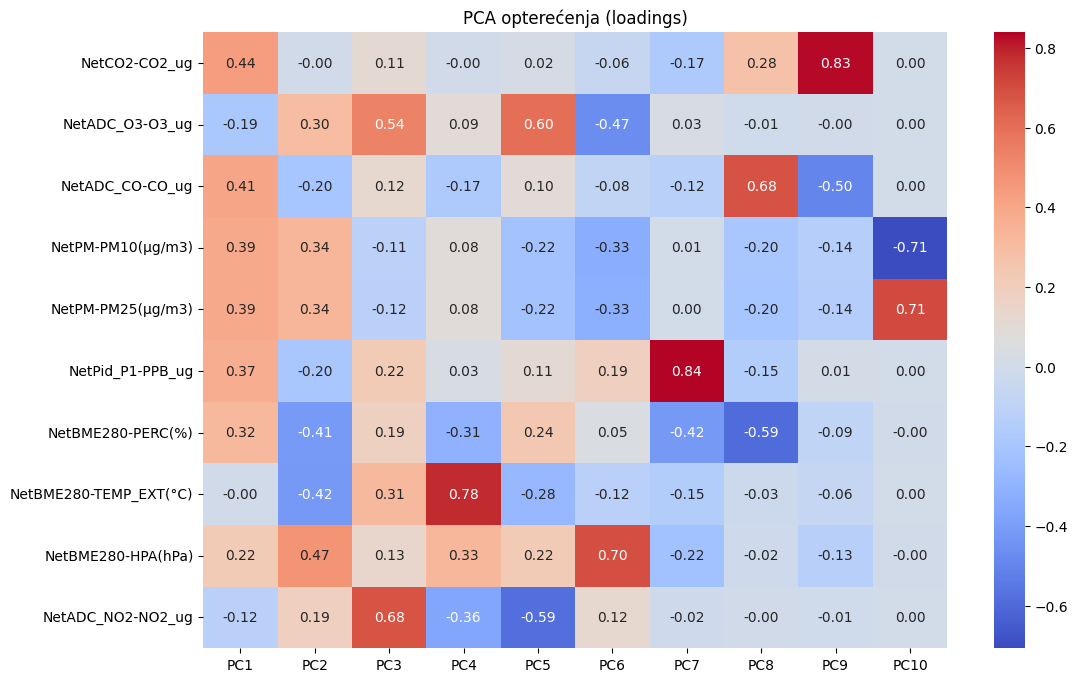

In [19]:
# Extract PCA components (loadings)
loadings = pca.components_.T  # Transpose to align with features
feature_names = parameters_for_PCA  # List of original feature names

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=feature_names)

# Plot heatmap for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA opterećenja (loadings)')
plt.show()


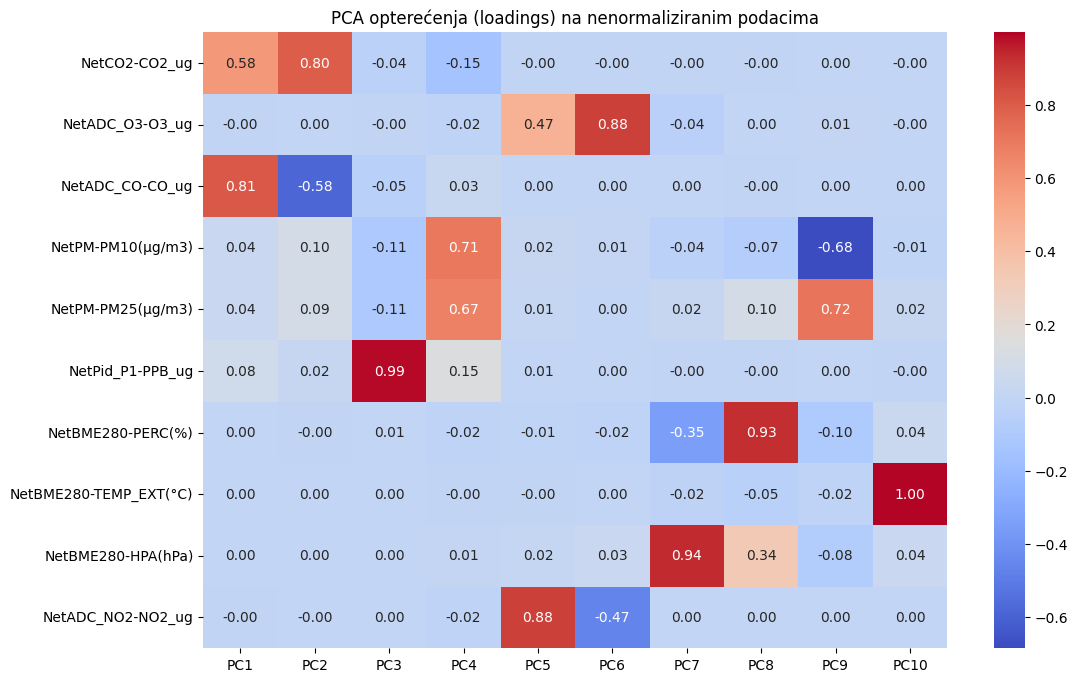

In [20]:
# Extract PCA components (loadings)
unnormalized_loadings = pca_unnormalized.components_.T  # Transpose to align with features
feature_names = parameters_for_PCA  # List of original feature names

# Create a DataFrame for loadings
unnormalized_loadings_df = pd.DataFrame(unnormalized_loadings, columns=[f'PC{i+1}' for i in range(unnormalized_loadings.shape[1])], index=feature_names)

# Plot heatmap for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(unnormalized_loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA opterećenja (loadings) na nenormaliziranim podacima')
plt.show()


# MODEL EVALUATION

### F1 SCORE

As	illustrated	in	Figure	2,	a	window	 opening	 state	is	defined, as	 one	 or	 successive	open	states	(full-cells)	bounded	by	one	or	successive	close	states	(empty-cells).	Both	models	evaluations	(2.i)	and	(2.ii)	provides	the	same	F1-score	values	whereas	both	provide	different	results	with	only	half	of	the	 openings	 perfectly	 detected	 for	 (2.i)	 and	 all	 openings	 detected	 but	 underestimated	 for	 (2.ii). Thus, we will need to introduce more domain oriented metrics focusing on window	opening	classification	and	evaluation	based	on	true	and	 false	opening	detection

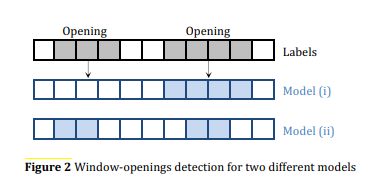

### TRUE AND FALSE OPENINGS

A	true	opening is	a	modeled	window	opening	that	corresponds	to	a	measured	window	opening	within	a	
given	time	step limit.	Therefore,	a	true	opening	is	a	true	positive	or	a	successive	set	of	true	positives	which	
may	include	 one	 or	more	 false	 positives.	 On	 the	 other	 hand,	 a	modeled	 window	 opening	 that	 does	 not	
satisfy	this	requirement	is	considered	as	a	false	opening.	Thus,	as	shown	in Figure	3,	for	a	time	limit	of	two	
time	 steps	 used	in	 this	 study,	 the	model	 results	 (3.i)	and	 (3.ii)	are	made	of	 two	and	 one	 true	 openings,	
respectively.	Six	evaluation	metrics	result	from	these	definitions,	the	total	true	and	false	openings	number,	
the	total	true	and	false	openings	time	and	the	average	true	opening	accuracy	score.

### Total	true	and	false	openings	number

These	metrics	are	used	to	evaluate	a	model	capability	to	detect	windows	openings	regardless	of	their	
duration and	correspond to	the	total	number	of	true	and	false	openings provided	by	a	model.

### Total	true	and	false	openings	time

These	 metrics	 are	 used	 to	 evaluate	 a	 model	 capability	 to	 quantify	 windows	 openings	 duration	 and	
correspond	to	the	total	amount	of	time for	all true	and	false	openings provided	by	a	model.	In	Figure	3,	the	
model	 results	 (3.i)	 has	a	 six	time	 step true	 opening	 time	and	 no	 false	 opening	 time	whereas	 the	model	
results	(3.ii)	has	a	three	time	step true	opening	times	for	a	five	time	step false	opening	times.

### Average	true	opening	accuracy	score

A score	is	associated	to	every	detected	opening	action	(represented	by	 the	 first	open	status	of	a	 true	
opening)	and	 to	every	detected	closing	action	(represented	by	 the	last	open	status	of	a	 true	opening) in	
order	 to	 evaluate	 a	 model	 precision	 on	 window-openings	 detection.	The	 score	 is	 set	 to	 1	 for	 a	 perfect	
match	between	 the	 true	opening	and	 the	measured	opening	and	is	linearly	decreased	by	0.33	 for	every	
time	step	difference.	The	penalty	of	0.33	is	chosen	regarding	the	two	time	step limit	set	to	define	true	and	
false	 openings.	Lastly,	 the	 accuracy score,	 specific	 to	 each	 opening,	is	 averaged	 for	 all	 the	 true	 opening	
provided	 by	 the	 model. In	 Figure	 3,	 the	 model	 results	 (3.i)	 has	 an	 average	 opening	 score	 of	 0.83	 and	
closing	score	of	0.66	whereas	the	model	results	(3.ii)	has	both	average	opening	and	closing	score	at	0.66.



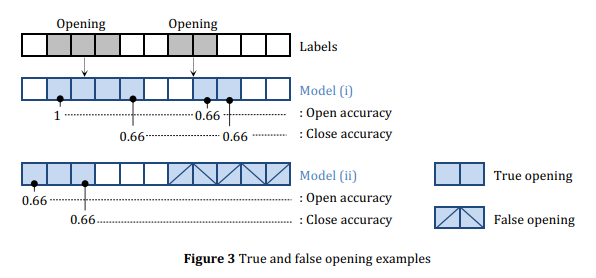

### Additional notes

This way of scoring the models is from a research paper, the data used are 1 minute time readings collected over 2 years, we have 4-5 second readings collected over 1 month. POTENTIAL ISSUE REGARDING THE ALLOWED TIME STEP LIMIT FOR TRUE AND FALSE OPENINGS, IS IT CORRECT TO TAKE 2 STEPS INTO ACCOUNT? FOR THEM IT'S 2 MINUTES FOR ME IT'S 8 SECONDS.

# MODELS WITH INDIVIDUAL PARAMETERS
We will try a couple of different classification models: XGBOOST, RFC, SVM, LDA, LSTM, GRU on NetADC_CO-CO_ug, as it seems to give a strong correlation to door opening, afterwards we will run the best model on the other parameters individually. We are focusing on recall

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(y_pred, y_test, name):
    cm = confusion_matrix(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("="*50)
    print(f"Results for {name}:")
    print(f"MCC: {mcc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    print("="*50)

## KNN

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Results for KNN:
MCC: 0.1005
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.95      0.86     47463
         1.0       0.39      0.11      0.17     13787

    accuracy                           0.76     61250
   macro avg       0.59      0.53      0.52     61250
weighted avg       0.70      0.76      0.70     61250

Confusion Matrix:



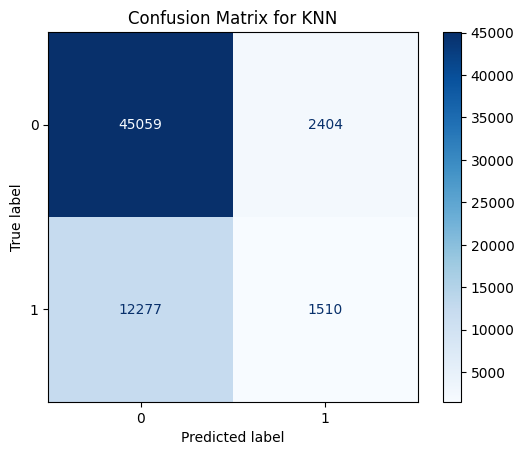

In [22]:
from sklearn.neighbors import KNeighborsClassifier

X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = sensor_df_normalized[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
evaluate_model(y_pred, y_test, "KNN")

### KNN with PCA

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Results for KNN:
MCC: 0.0580
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.74      0.76     47463
         1.0       0.26      0.32      0.29     13787

    accuracy                           0.65     61250
   macro avg       0.53      0.53      0.53     61250
weighted avg       0.67      0.65      0.66     61250

Confusion Matrix:



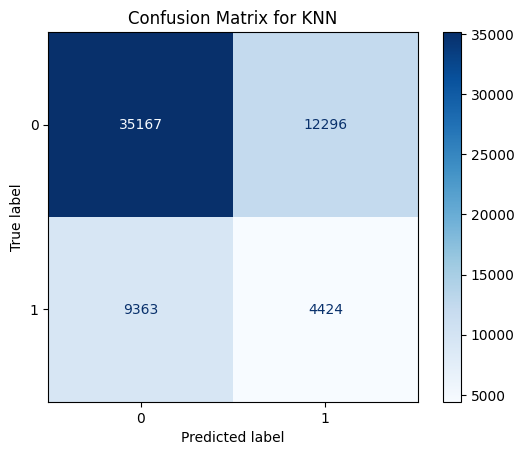

In [23]:
from sklearn.neighbors import KNeighborsClassifier

y = sensor_df_normalized[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
evaluate_model(y_pred, y_test, "KNN")

## GRU

### GRU v1

Epoch 1/30


C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7657/7657 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8705 - loss: 0.3217 - val_accuracy: 0.7037 - val_loss: 0.5612
Epoch 2/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9074 - loss: 0.2294 - val_accuracy: 0.6554 - val_loss: 0.8979
Epoch 3/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9219 - loss: 0.1940 - val_accuracy: 0.6334 - val_loss: 1.2494
Epoch 4/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9316 - loss: 0.1750 - val_accuracy: 0.6569 - val_loss: 1.3554
Epoch 5/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9365 - loss: 0.1628 - val_accuracy: 0.6177 - val_loss: 1.7742
Epoch 6/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9404 - loss: 0.1519 - val_accuracy: 0.5695 - val_loss: 2.7531
Epoch 7/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9437 - loss: 0.1455 - val_accuracy: 0.5794 - val_loss: 2.8467
Epoch 8/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9464 - loss: 0.1388 - val

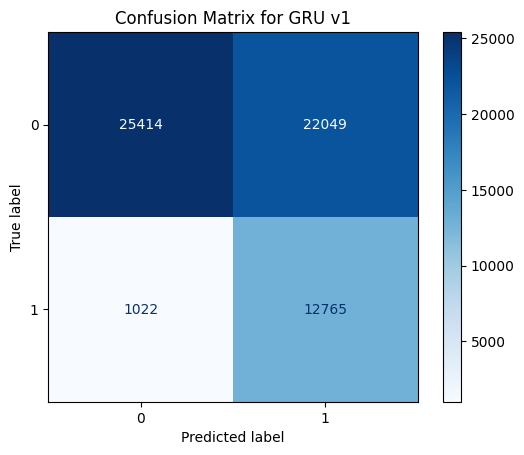

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.25).astype(int)  # Convert probabilities to binary predictions

evaluate_model(y_pred, y_test, "GRU v1")

### GRU v2

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8553 - loss: 0.3628 - val_accuracy: 0.8090 - val_loss: 0.4433
Epoch 2/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8904 - loss: 0.2711 - val_accuracy: 0.6053 - val_loss: 0.5717
Epoch 3/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9032 - loss: 0.2421 - val_accuracy: 0.5817 - val_loss: 0.6785
Epoch 4/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9084 - loss: 0.2292 - val_accuracy: 0.5868 - val_loss: 0.8839
Epoch 5/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9124 - loss: 0.2181 - val_accuracy: 0.5778 - val_loss: 1.2884
Epoch 6/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9141 - loss: 0.2117 - val_accuracy: 0.5674 - val_loss: 1.5888
Test Loss: 0.4433, Test Accuracy: 0.8090
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Results for GRU v2:
MCC: 0.3730
Classification Report:
               precision    recall  f1-score   support

         0.0       

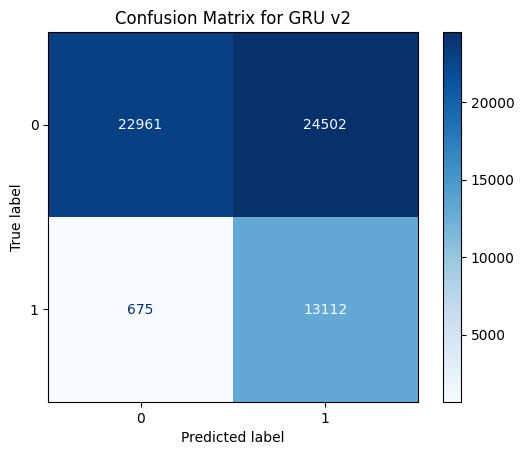

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential([
    GRU(16, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.15).astype(int)  
# 0.1 MCC = 0.5
# 0.2 MCC = 0.4
evaluate_model(y_pred, y_test, "GRU v2")

## XGBoost

### Unnormalized data

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [17:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results for XGBoost:
MCC: 0.0123
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85     47463
         1.0       0.25      0.07      0.10     13787

    accuracy                           0.74     61250
   macro avg       0.51      0.50      0.48     61250
weighted avg       0.66      0.74      0.68     61250

Confusion Matrix:



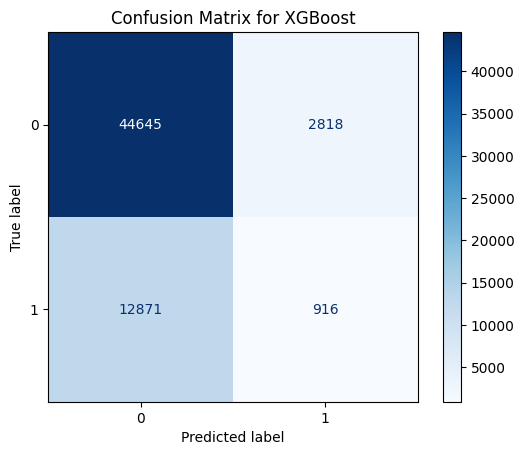

In [25]:
from xgboost import XGBClassifier

X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
evaluate_model(y_pred, y_test, "XGBoost")

### Normalized data

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [17:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results for XGBoost:
MCC: 0.0123
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85     47463
         1.0       0.25      0.07      0.10     13787

    accuracy                           0.74     61250
   macro avg       0.51      0.50      0.48     61250
weighted avg       0.66      0.74      0.68     61250

Confusion Matrix:



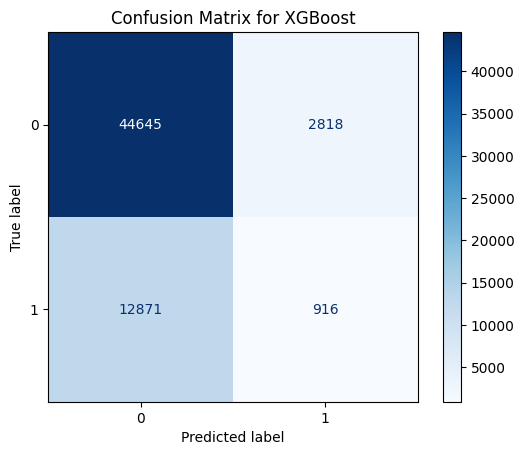

In [26]:
from xgboost import XGBClassifier

X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = sensor_df_normalized[['any_door_open']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
evaluate_model(y_pred, y_test, "XGBoost")

The results for normalized and unnormalized data are identical

## RFC

### RFC unnormalized data

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Results for RFC:
MCC: 0.0846
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.90      0.84     47463
         1.0       0.32      0.17      0.22     13787

    accuracy                           0.73     61250
   macro avg       0.55      0.53      0.53     61250
weighted avg       0.68      0.73      0.70     61250

Confusion Matrix:



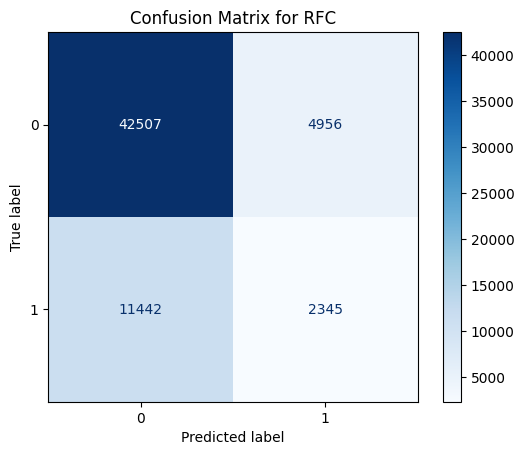

In [22]:
from sklearn.ensemble import RandomForestClassifier

X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluate_model(y_pred, y_test, "RFC")

### RFC normalized data

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Results for RFC normalized:
MCC: 0.0817
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.90      0.84     47463
         1.0       0.32      0.17      0.22     13787

    accuracy                           0.73     61250
   macro avg       0.55      0.53      0.53     61250
weighted avg       0.68      0.73      0.70     61250

Confusion Matrix:



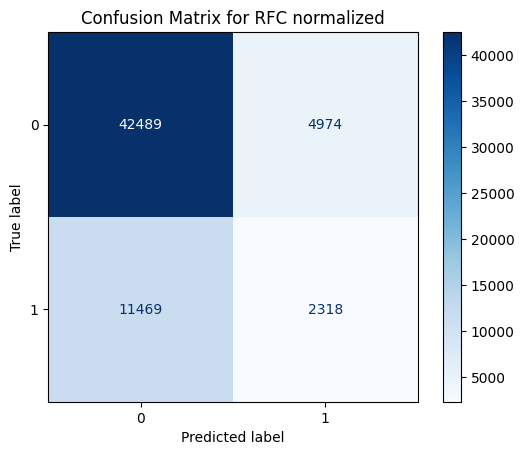

In [24]:
from sklearn.ensemble import RandomForestClassifier

X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = sensor_df_normalized[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluate_model(y_pred, y_test, "RFC normalized")

RFC with unnormalized data is sligthy better performing, but the difference is negligible

### RFC with SMOTE resampling

Results for RFC:
MCC: 0.0725
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.80      0.80     47463
         1.0       0.28      0.27      0.28     13787

    accuracy                           0.68     61250
   macro avg       0.54      0.54      0.54     61250
weighted avg       0.68      0.68      0.68     61250

Confusion Matrix:



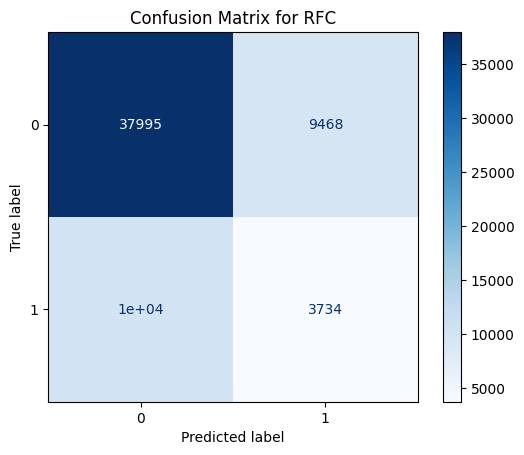

In [25]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE  # For SMOTE

X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = sensor_df_normalized[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluate_model(y_pred, y_test, "RFC")

F1 went up from 22% to 28%, but more importantly recall went up from 17% to 27%

In [86]:
# Code for plotting only 'NetADC_CO-CO_ug' for current days, with vertical lines for door open times
"""
start_time = '2024-10-18'  
end_time = '2024-10-19'

sensor_df_normalized.set_index('timestamp(ZG)', inplace=True)
data_resampled = sensor_df_normalized.resample('1T').mean()
data_resampled.reset_index(inplace=True)

filtered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]

# Set up the figure for a single plot
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('NetADC_CO-CO (µg) over Time', fontsize=16)

# Plot only the 'NetADC_CO-CO_ug' parameter
ax.plot(filtered_resampled_df['timestamp(ZG)'], filtered_resampled_df['NetADC_CO-CO_ug'], label='NetADC_CO-CO (µg)', color='b')

# Add vertical lines only when 'any_door_open' is True
open_door_times = filtered_resampled_df[filtered_resampled_df['any_door_open'] == 1]['timestamp(ZG)']
for open_time in open_door_times:
    ax.axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.2)

predicted_times = filtered_resampled_df.iloc[:len(y_pred)]['timestamp(ZG)']  # Get corresponding timestamps
# Add vertical lines for y_pred = 1 (door open)
for idx, pred in enumerate(y_pred):
    if pred == 1:
        ax.axvline(x=predicted_times.iloc[idx], color='r', linestyle='-', lw=2, alpha=0.2)

# Set axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('NetADC_CO-CO (µg)')

# Rotate x-axis ticks for better visibility
ax.tick_params(axis='x', rotation=45)

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\nstart_time = '2024-10-18'  \nend_time = '2024-10-19'\n\nsensor_df_normalized.set_index('timestamp(ZG)', inplace=True)\ndata_resampled = sensor_df_normalized.resample('1T').mean()\ndata_resampled.reset_index(inplace=True)\n\nfiltered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]\n\n# Set up the figure for a single plot\nfig, ax = plt.subplots(figsize=(15, 8))\nfig.suptitle('NetADC_CO-CO (µg) over Time', fontsize=16)\n\n# Plot only the 'NetADC_CO-CO_ug' parameter\nax.plot(filtered_resampled_df['timestamp(ZG)'], filtered_resampled_df['NetADC_CO-CO_ug'], label='NetADC_CO-CO (µg)', color='b')\n\n# Add vertical lines only when 'any_door_open' is True\nopen_door_times = filtered_resampled_df[filtered_resampled_df['any_door_open'] == 1]['timestamp(ZG)']\nfor open_time in open_door_times:\n    ax.axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.2)\n\npredicted_times = filtered_resampled_df.iloc[:

## SVM

Takes too long to train >15 min

In [14]:
"""
from sklearn.svm import SVC

# Support Vector Machine (SVM)
X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
svm = SVC()
svm.fit(X_train, y_train)
evaluate_model(svm, X_test, y_test, "SVM")
"""

'\nfrom sklearn.svm import SVC\n\n# Support Vector Machine (SVM)\nX = merged_df[[\'NetADC_CO-CO_ug\']].values\ny = merged_df[[\'any_door_open\']].values\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)\nsvm = SVC()\nsvm.fit(X_train, y_train)\nevaluate_model(svm, X_test, y_test, "SVM")\n'

## LDA

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Linear Discriminant Analysis (LDA)
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
evaluate_model(y_pred, X_test, y_test, "LDA")

c:\Users\tjura\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Results for LDA:
Accuracy: 0.7749061224489796
F1 Score: 0.0
Confusion Matrix:
 [[47463     0]
 [13787     0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      1.00      0.87     47463
         1.0       0.00      0.00      0.00     13787

    accuracy                           0.77     61250
   macro avg       0.39      0.50      0.44     61250
weighted avg       0.60      0.77      0.68     61250



c:\Users\tjura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tjura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tjura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Let's try an RFC MODEL with the PCA components

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Results for PCA RFC:
MCC: 0.2165
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.95      0.87     47463
         1.0       0.52      0.20      0.28     13787

    accuracy                           0.78     61250
   macro avg       0.66      0.57      0.58     61250
weighted avg       0.74      0.78      0.74     61250

Confusion Matrix:



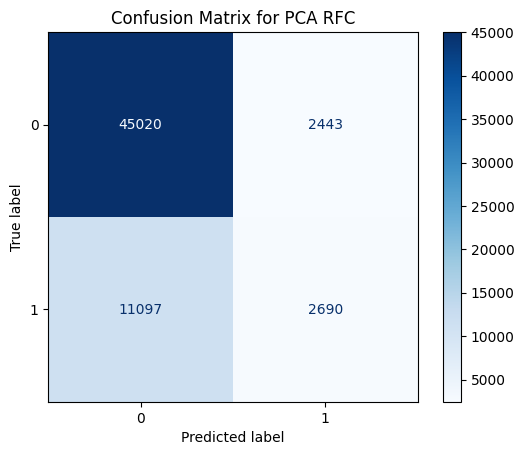

In [26]:
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluate_model(y_pred, y_test, "PCA RFC")

C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Results for PCA RFC:
MCC: 0.3614
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.96      0.89     47463
         1.0       0.70      0.29      0.41     13787

    accuracy                           0.81     61250
   macro avg       0.76      0.63      0.65     61250
weighted avg       0.79      0.81      0.78     61250

Confusion Matrix:



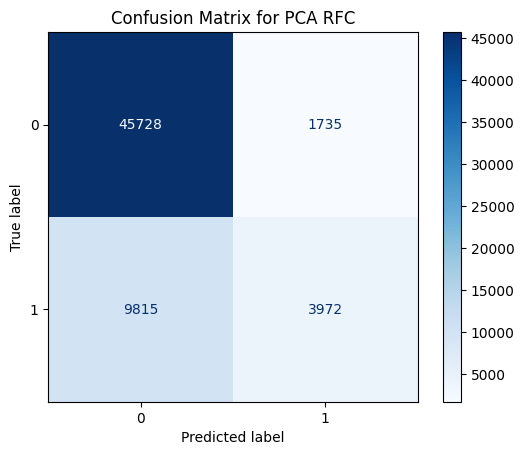

In [58]:
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca_unnormalized, y, test_size=0.2, shuffle=False)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluate_model(y_pred, y_test, "PCA RFC")

### RFC with PCA, SMOTE

#### Normalized

Results for PCA RFC:
MCC: 0.1633
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.97      0.87     47463
         1.0       0.54      0.11      0.18     13787

    accuracy                           0.78     61250
   macro avg       0.67      0.54      0.52     61250
weighted avg       0.73      0.78      0.72     61250

Confusion Matrix:



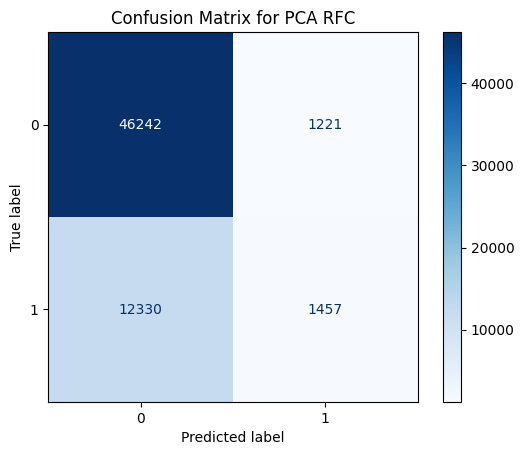

In [28]:
# Step 1: Split the data
X = sensor_df_normalized[parameters_for_PCA]
y = merged_df['any_door_open'].values  # Ensure this is a 1D array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 2: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Apply PCA to the resampled training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)  # Apply the same PCA transformation to the test set

# Step 4: Train the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_pca, y_train_resampled)

# Step 5: Predict on the PCA-transformed test set
y_pred = rfc.predict(X_test_pca)

evaluate_model(y_pred, y_test, "PCA RFC")

#### Unnormalized

Results for PCA RFC:
MCC: 0.2097
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.86      0.84     47463
         1.0       0.41      0.33      0.37     13787

    accuracy                           0.74     61250
   macro avg       0.61      0.60      0.60     61250
weighted avg       0.72      0.74      0.73     61250

Confusion Matrix:



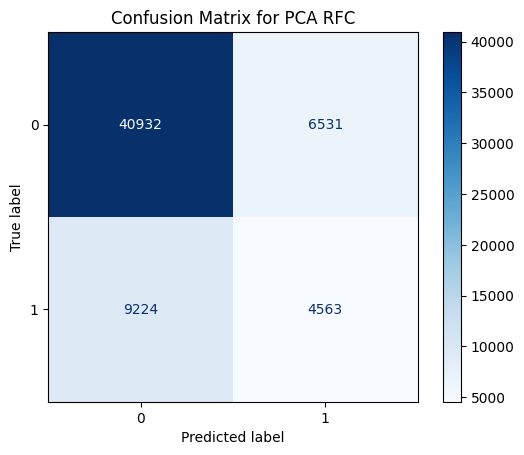

In [27]:
# Step 1: Split the data
X = merged_df[parameters_for_PCA]
y = merged_df['any_door_open'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 2: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Apply PCA to the resampled training data
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

# Step 4: Train the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_pca, y_train_resampled)

# Step 5: Predict on the PCA-transformed test set
y_pred = rfc.predict(X_test_pca)

evaluate_model(y_pred, y_test, "PCA RFC")